# Bayesian Analysis of Math Exam Scores

## Problem Statement

We were provided with a dataset of math exam scores from Estonian primary schools. Our task was to build a Bayesian model to better understand the factors that influence exam performance.

## Data Description

The dataset includes the following variables:
- `year`: The year of the exam (2016-2023), with [2020 missing due to the COVID-19 pandemic](https://www.ohtuleht.ee/998159/pohikooli-eksamid-jaavad-ara-riigieksamid-toimuvad)
- `county`: The county where the student took the exam
- `domestic_background`: Whether the student is Estonian or Russian
- `gender`: Student's gender (Male/Female)
- `avg_grade`: The student's average grade (from 1 to 5, continuous)
- `exam_score`: The exam score (0-50 points)


In [19]:
# Import libraries, import and manipulate 
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load the data
df = pd.read_csv('math_exam_scores.csv', sep=";").sample(10000) # Work with a smaller dataset at first so that you don't have to wait 10 minutes every time you sample the model.
#df = pd.read_csv('math_exam_scores.csv', sep=";") 

# DATA MANIPULATIONS #
## YEAR ##
# Convert year to category as there are probably non-linear effects at play
df['year_orig'] = df['year']
df['year'] = df['year'].astype('category')

# Encode categorical variable 'year' as integers for indexing
df['year'] = df['year'].cat.codes
n_years = df['year'].nunique()

## COUNTY ##
# Make sure county is a category
df['county'] = df['county'].astype('category')

# Encode categorical variable 'county'
df['county'] = df['county'].cat.codes
n_counties = df['county'].nunique()

## GENDER ##
# Convert domestic_background to numerical binary
remap = {'Male': 0, 'Female': 1}
pd.set_option("future.no_silent_downcasting", True)
df['gender'] = df['gender'].replace(remap).values.astype(int)

## DOMESTIC BACKGROUND ##
# Convert domestic_background to numerical binary
remap = {'Estonian': 0, 'Russian': 1}
df['domestic_background'] = df['domestic_background'].replace(remap).values.astype(int)

## CONTINIOUS VARIABLES ##
# Rescaling exam score and since the Beta distribution is the most intuitive choice, then make sure that
#  the rescled exam score is strictly within open interval (0,1), ie. cannot be [0,1].
eps = 1e-6
df['exam_score_rescaled'] = (df['exam_score'] / 50.0).clip(eps, 1-eps)

# Rescaling avg_grade
df['avg_grade_rescaled'] = df['avg_grade'] / 5.0

models = {}
df.describe().round(2)

,year,county,domestic_background,gender,exam_score,avg_grade,year_orig,exam_score_rescaled,avg_grade_rescaled
count,10000.00,10000.00,10000.00,10000.0,10000.00,10000.00,10000.00,10000.00,10000.00
mean,3.15,4.05,0.22,0.5,37.19,3.76,2019.61,0.74,0.75
std,2.03,4.79,0.41,0.5,10.43,0.97,2.48,0.21,0.19
min,0.00,0.00,0.00,0.0,1.00,0.28,2016.00,0.02,0.06
25%,1.00,0.00,0.00,0.0,31.00,3.16,2017.00,0.62,0.63
50%,3.00,2.00,0.00,0.0,40.00,3.98,2019.00,0.80,0.80
75%,5.00,8.00,0.00,1.0,46.00,4.55,2022.00,0.92,0.91
max,6.00,14.00,1.00,1.0,50.00,5.00,2023.00,1.00,1.00


## Problem analysis

The DAG that we'll take as the basis of our analysis.

<img src="pics/DAG.png" alt="drawing" width="400"/>

### Justification for the DAG

**Year** - Since this standardised matematics exam is administered to the whole country simultaneously in set year, then all of the possible environemental and occasional influencing factors are captured in this here. Exam exercises are changed every year, so [some years tend to be easier](https://www.err.ee/1609007237/pohikooli-matemaatikaeksami-sooritused-olid-paremad-kui-kahel-eelneval-aastal) and some harder, there are global effects that come into play (eg. COVID-19 pandemic), policy changes, cohort effects etc.<br>
Since all other variables result from a progression of longer processes (eg. county effects on exam score) and any shift in them cannot be attributed to a single year, then Year of the exam does not have influence on other factors.

**County** - Differences in school education quality, population parameters (eg. urban/rural porportions), socio/economic factors are encompassed into the county variable. For that reason county is set to influence academic ability and average grade. <br>
The distribution of Estonian and Russian speaking families is different between counties. Therefore county -> domestic_background. 

**Domestic background** - [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that Estonian and Russian students' academic ability differ quite a lot in Estonia.

**Gender** - [PISA statistics](https://harno.ee/sites/default/files/documents/2023-12/Pisa_tulemused_2022_veebi.pdf) show that there is a gap in academic ability between boys and girls in Estonia.

**Academic ability** - Exam score is meant to measure academic ability of a student, but its an approximation. Its taken as a latent variable into the model. Academic ability is influenced by multiple factors such as school education quality, environment (mediated by county), domestic background and gender etc. <br> 
Average grade also tries to measure academic ability, but has other influencing factors at play (eg. group level effects of school and county, girls tend to worry more about grades than boys). So it cannot be taken as the same kind of measure of academic ability as the exam score.

**Average grade** - Average grade is another attempt at measuring academic ability, but is less standardised. It is also dependent on group level effects from schools and thus counties, ie. a '4' in Harjumaa is likely not the same as a '4' in Võrumaa. Since its a an outcome of academic ability, then it is highly correlated with exam score. <br>
Average grade does however influences **the variability of exam score**, ie. students who have average grade near 5 are probably very good at exams and tests. Knowledge enables them to be faster, thus having more time to overlook the exam submission, finding typos and small mistakes. On the opposite end of the spectrum students who have a very low average grade will probably also struggle on the exam, so its vey unlikely they will suddenly score much points on the exam, therefore variability is also lower.


## Let's model

Since exam score is bounded within [0,50] and with a hockey stick shape (see graph below), then there were 3 distribution options considered: 

* **Rescaled Beta distribution** (bounded to (0,1) and based on parameters can model highly skewed data)
* **Binomial distribution** (bounded to (0,50) and represents 50 single Bernoulli trials that translates to getting 1 point from given exercise).
* **Truncated Normal distribution** (if exam score wouldn't have an upper bound and gathering point would be free, then the exam score would probably be normally distributed. Now it is truncated at the 50 point mark).

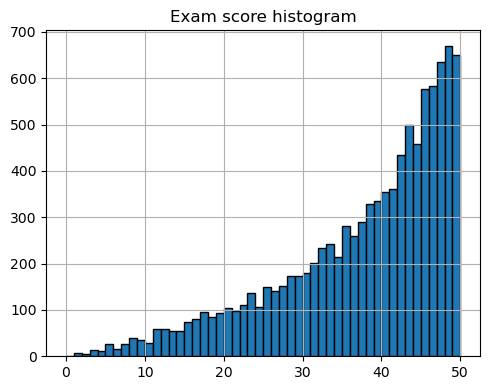

In [13]:
df['exam_score'].hist(bins=50, figsize=(5, 4), edgecolor='black')
plt.title('Exam score histogram')
plt.tight_layout()
plt.show()

### Heteroscedacity

Initial data analysis showed that variance of exam score is smaller towards the end points of the scale - so near 0 and 50. See graphs with average grade below.  

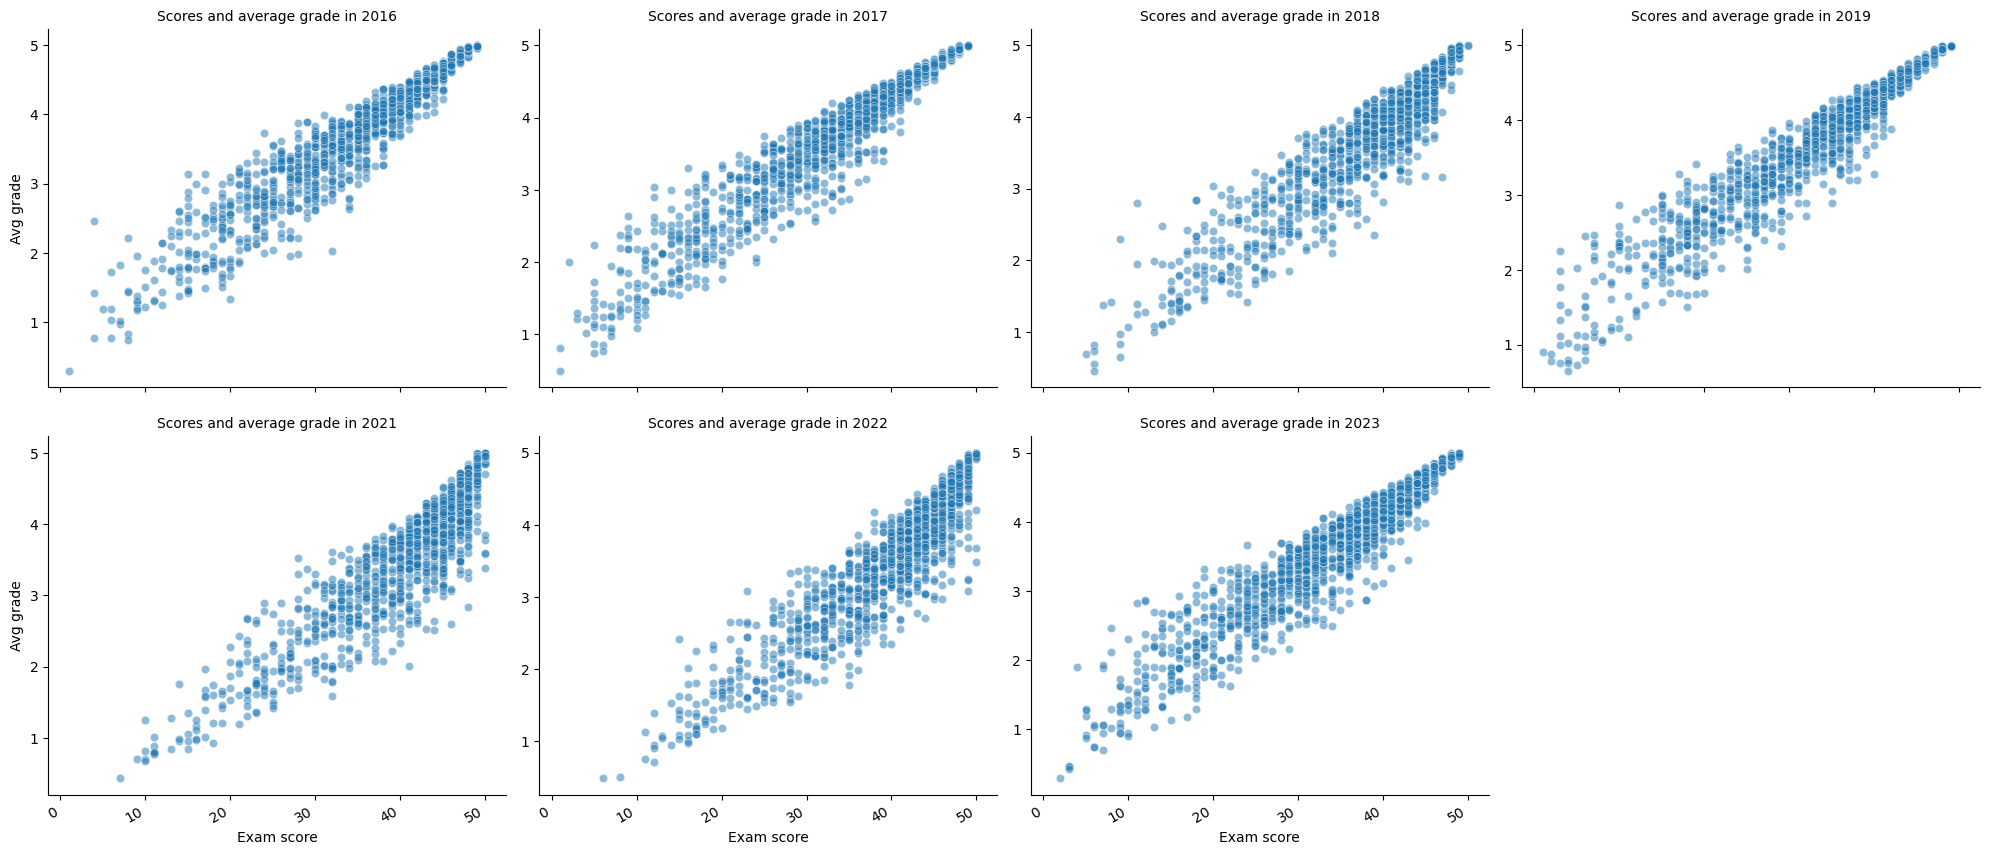

In [24]:
g = sns.FacetGrid(df, col='year_orig', sharey=False, height=5, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="exam_score", y="avg_grade", alpha=0.5)
g.set_axis_labels("Exam score", "Avg grade")
g.set_titles("Scores and average grade in {col_name}")
g.fig.autofmt_xdate()
#g.add_legend(title="Domestic Background")
plt.show()

### List of models

Besides the 3 three mentioned distribution we then also fitted a model with heteroscedacity taken into account and a Full luxury Bayes model.

Final list of models:

**Models with Beta distribution:**
1. Model with only year (model_beta_m1)
1. Model with academic ability and year (model_beta_m2)
1. Model with academic ability, average grade and year (model_beta_m3)
1. Model with academic ability, average grade and year, $\beta$ is variable (model_beta_m4)
4. Model with heteroscedacity 4 (model_beta_heterosc4)
1. Full luxury Bayes(model_beta_luxury)

**Models with Binomial distribution:**
1. Model with only year (model_binomial_m1)
1. Model with academic ability, average grade and year (model_binomial_m4)

**Models with Truncated normal distribution:**
1. Best model m4 with Truncated Normal (model_trunc_normal_m4)

## Model comparison

Comparing the models with Expected log pointwise predictive density (ELPD) estimated using Pareto smoothed importance sampling (PSIS) Leave-one-out Cross-validation (LOO).

<img src="pics/model_comparison.png" alt="drawing" width="500"/>


In [25]:
random.seed(1234)

with pm.Model() as model_beta_heterosc4:    
    # Priors to modeling academic_ability
    acad_intercept = pm.Normal("acad_intercept", mu=0, sigma=1)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=1)
    beta_domestic = pm.Normal("beta_domestic", mu=0, sigma=1)
    beta_county = pm.Normal("beta_county", mu=0, sigma=1, shape=n_counties)
    
    # Latent variable: academic ability
    mu = (acad_intercept
        + beta_gender * df.gender
        + beta_domestic * df.domestic_background
        + beta_county[df.county])
    academic_ability = pm.Normal("academic_ability", mu=mu, sigma=1)

    # Priors to modeling exam score
    phi_intercept = pm.Normal("phi_intercept", mu=0, sigma=1)
    kappa_intercept = pm.Normal("kappa_intercept", mu=0, sigma=1)
    beta_academic = pm.Normal("beta_academic", mu=0, sigma=1)
    beta_year = pm.Normal("beta_year", mu=0, sigma=1, shape=n_years)
    beta_grade1 = pm.Normal("beta_grade1", mu=0, sigma=1)
    beta_grade2 = pm.Normal("beta_grade2", mu=0, sigma=1)

    # Based on https://distribution-explorer.github.io/continuous/beta.html trying to reparametrize with phi and kappa 
    # Where phi is the mean and kappa is variance
    phi = pm.math.sigmoid(phi_intercept + beta_academic*academic_ability + beta_grade1*df.avg_grade + beta_year[df.year]) + eps
    kappa = kappa_intercept + beta_grade2 * df.avg_grade
    
    y_obs = pm.Beta("y_obs", alpha=phi*kappa, beta=(1-phi)*kappa, observed=df.exam_score_rescaled)
        
    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    models['model_beta_heterosc4'] = trace

# Summary
var_names=[c for c in list(trace.posterior.data_vars) if not(c.startswith('academic_ability') or c.startswith('heteroscedacity_component'))]
az.summary(trace, round_to=2, var_names=var_names) 

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [acad_intercept, beta_gender, beta_domestic, beta_county, academic_ability, phi_intercept, kappa_intercept, beta_academic, beta_year, beta_grade1, beta_grade2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2019 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acad_intercept,-0.24,0.63,-1.53,0.62,0.28,0.14,6.34,25.67,1.69
beta_gender,0.02,0.06,-0.10,0.12,0.02,0.01,8.45,31.95,1.41
beta_domestic,0.25,0.44,-0.57,0.62,0.22,0.13,7.22,42.79,1.53
beta_county[0],0.29,0.54,-0.78,1.09,0.24,0.12,7.36,35.97,1.56
beta_county[1],-0.06,0.36,-0.72,0.63,0.05,0.01,47.08,510.16,1.08
beta_county[2],0.49,0.86,-1.22,1.50,0.41,0.22,7.27,32.87,1.56
beta_county[3],-0.29,0.59,-1.12,0.89,0.26,0.13,7.18,28.10,1.55
beta_county[4],0.49,0.86,-1.22,1.50,0.41,0.22,7.20,31.37,1.57
beta_county[5],-0.45,0.86,-1.45,1.21,0.41,0.22,7.19,27.31,1.56
beta_county[6],0.23,0.49,-0.69,1.07,0.20,0.09,7.74,32.14,1.50


                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
acad_intercept -0.241  0.633  -1.530    0.624      0.281    0.141       6.0   
beta_gender     0.025  0.061  -0.103    0.122      0.022    0.009       8.0   
beta_domestic   0.252  0.444  -0.574    0.624      0.219    0.125       7.0   
beta_county[0]  0.285  0.541  -0.775    1.089      0.235    0.117       7.0   
beta_county[1] -0.065  0.364  -0.721    0.631      0.053    0.011      47.0   
...               ...    ...     ...      ...        ...      ...       ...   
beta_year[4]    0.425  0.345  -0.227    1.067      0.014    0.008     612.0   
beta_year[5]    0.251  0.345  -0.384    0.908      0.014    0.008     613.0   
beta_year[6]   -0.625  0.346  -1.256    0.041      0.014    0.008     612.0   
beta_grade1     1.174  0.006   1.164    1.184      0.000    0.000    2768.0   
beta_grade2     9.663  0.371   8.952   10.316      0.013    0.006     761.0   

                ess_tail  r_hat  
acad_intercept   

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x14c92e520> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

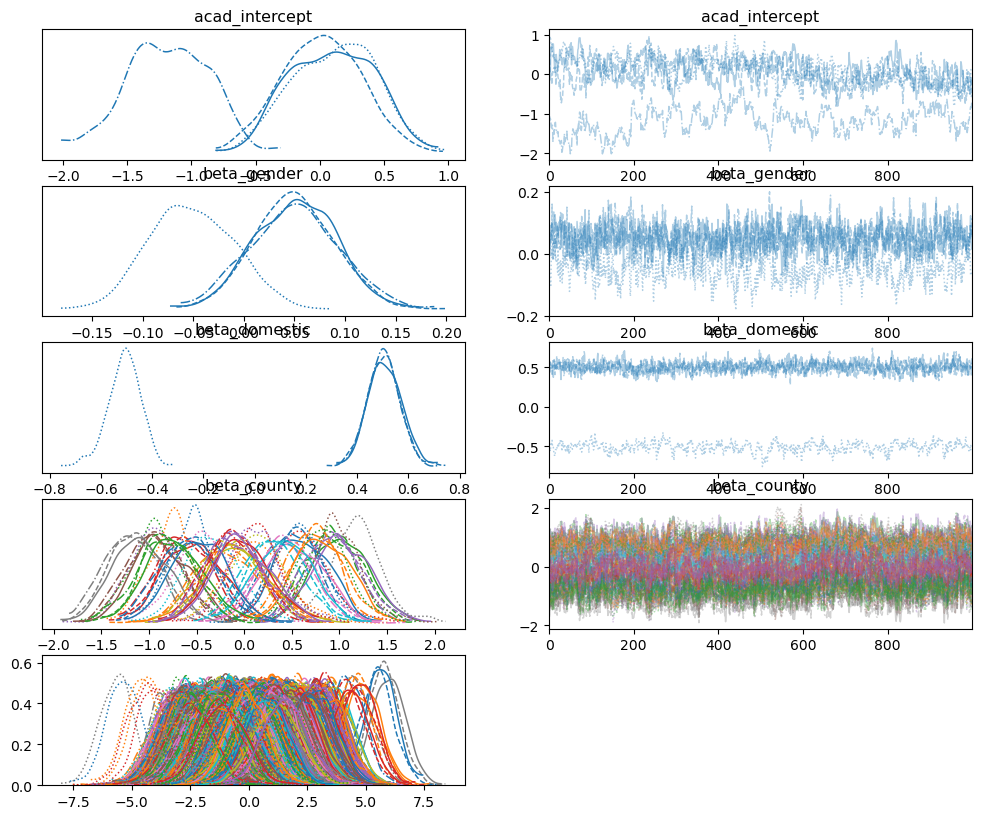

In [26]:
# Model diagnostics
print(pm.summary(trace))
pm.plot_trace(trace)

<Axes: xlabel='y_obs'>

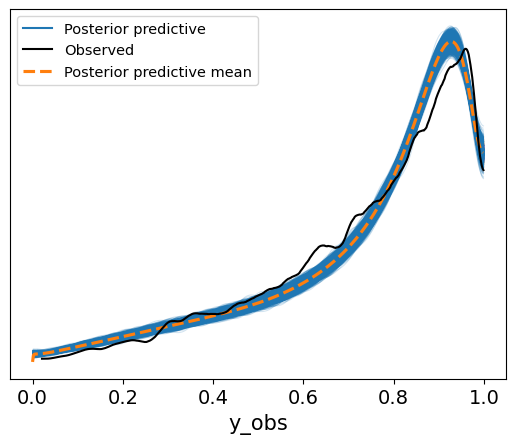

In [27]:
pm.plot_ppc(trace)

/opt/anaconda3/envs/bayes2025_backup/lib/python3.12/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (10030) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'acad_intercept'}>,
        <Axes: title={'center': 'beta_gender'}>,
        <Axes: title={'center': 'beta_domestic'}>,
        <Axes: title={'center': 'beta_county\n0'}>],
       [<Axes: title={'center': 'beta_county\n1'}>,
        <Axes: title={'center': 'beta_county\n2'}>,
        <Axes: title={'center': 'beta_county\n3'}>,
        <Axes: title={'center': 'beta_county\n4'}>],
       [<Axes: title={'center': 'beta_county\n5'}>,
        <Axes: title={'center': 'beta_county\n6'}>,
        <Axes: title={'center': 'beta_county\n7'}>,
        <Axes: title={'center': 'beta_county\n8'}>],
       [<Axes: title={'center': 'beta_county\n9'}>,
        <Axes: title={'center': 'beta_county\n10'}>,
        <Axes: title={'center': 'beta_county\n11'}>,
        <Axes: title={'center': 'beta_county\n12'}>],
       [<Axes: title={'center': 'beta_county\n13'}>,
        <Axes: title={'center': 'beta_county\n14'}>,
        <Axes: title={'center': 'academic_ability\n0'}>,
  

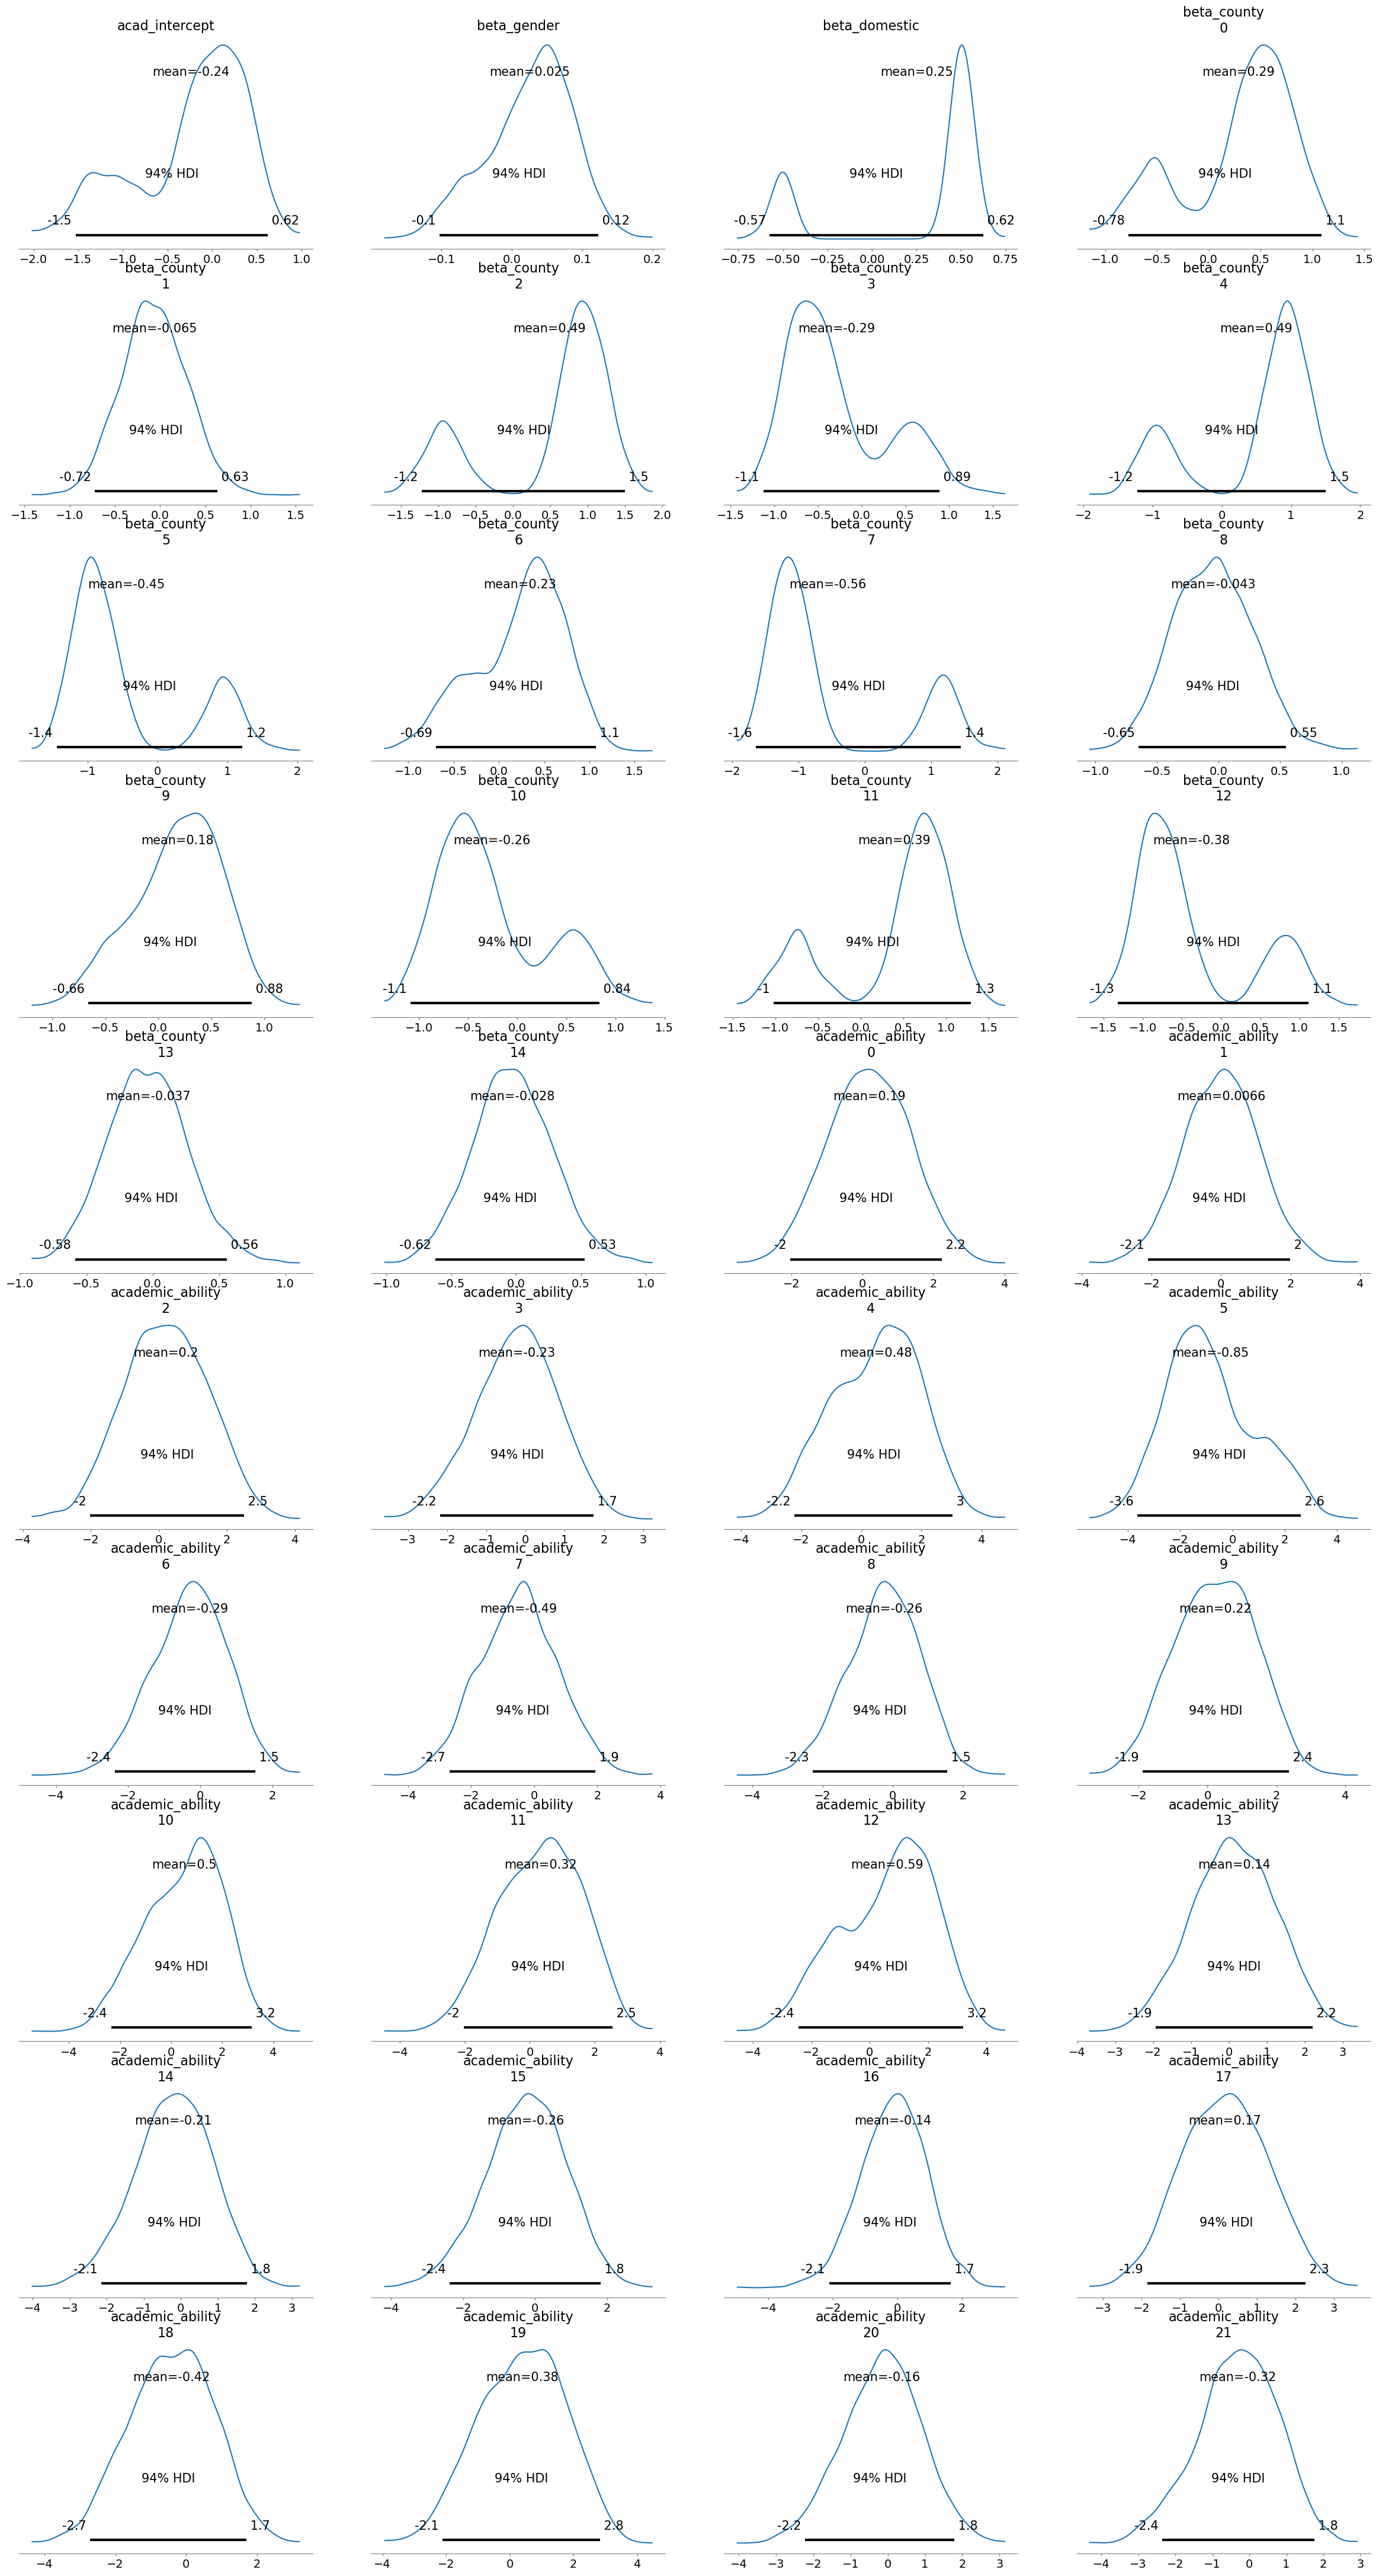

In [30]:
pm.plot_posterior(trace)